<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/basics/brain-class.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/basics/brain-class.ipynb)

# The Brain Class

A fundamental aspect of deep learning involves iterating through a dataset multiple times and updating model parameters, commonly referred to as the "training loop." To streamline and organize this process, SpeechBrain offers a versatile framework in the form of the "Brain" class, implemented in `speechbrain/core.py`. In each recipe, this class is sub-classed, and its methods are overridden to tailor the implementation to the specific requirements of that recipe.

The core method of the Brain class is `fit()`, responsible for iterating through the dataset, performing updates to the model, and managing the training loop. To leverage `fit()`, at least two methods must be defined in the sub-class: `compute_forward()` and `compute_objectives()`. These methods handle the computation of the model for generating predictions and the calculation of loss terms required for gradient computation.

Let's explore a minimal example to illustrate this:


In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

In [ ]:
import torch
import speechbrain as sb

class SimpleBrain(sb.Brain):
  def compute_forward(self, batch, stage):
    return self.modules.model(batch["input"])


  def compute_objectives(self, predictions, batch, stage):
    return torch.nn.functional.l1_loss(predictions, batch["target"])

model = torch.nn.Linear(in_features=10, out_features=10)
brain = SimpleBrain({"model": model}, opt_class=lambda x: torch.optim.SGD(x, 0.1))
data = [{"input": torch.rand(10, 10), "target": torch.rand(10, 10)}]
brain.fit(range(10), data)

With just around 10 lines of code, we can successfully train a neural model. This efficiency is achieved because the Brain class handles intricate details of training, such as managing `train()` and `eval()` states or computing and applying gradients. Furthermore, the flexibility of the class allows every step of the process to be overridden by adding methods to the sub-class. This means that even intricate training procedures, such as those involved in Generative Adversarial Networks (GAN), can be seamlessly integrated into the Brain class.

In this tutorial, we'll begin by elucidating the parameters of the Brain class. Subsequently, we'll delve into the `fit()` method, breaking it down step by step and highlighting the segments that can be overridden when necessary. These insights into the class's parameters and the `fit()` method form the foundation for understanding the functionality and versatility of the Brain class.


## Arguments to `Brain` class

The Brain class only takes 5 arguments, but each of these can be a little complex, so we explain them in detail here. The relevant code is just the `__init__` definition:

```python
def __init__(
    self,
    modules=None,
    opt_class=None,
    hparams=None,
    run_opts=None,
    checkpointer=None,
):
```

### `modules` argument

This first argument takes a dictionary of torch modules. The Brain class takes this dictionary and converts it to a Torch ModuleDict. This provides a convenient way to move all parameters to the correct device, call `train()` and `eval()`, and wrap the modules in the appropriate distributed wrapper if necessary.

### `opt_class` argument

The Brain class takes a function definition for a pytorch optimizer. The reason for choosing this as input rather than a pre-constructed pytorch optimizer is that the Brain class automatically handles wrapping the module parameters in distributed wrappers if requested. This needs to happen before the parameters get passed to the optimizer constructor.

To pass a pytorch optimizer constructor, a lambda can be used, as in the example at the beginning of this tutorial. More convenient, however, is the option used by most of the recipes in SpeechBrain: define the constructor with HyperPyYAML. The `!name:` tag acts similarly to the lambda, creating a new constructor that can be used to make optimizers.

```yaml
optimizer: !name:torch.optim.Adam
    lr: 0.1
```

Of course sometimes zero or multiple optimizers are required. In the case of multiple optimizers, the `init_optimizers` method can be overridden to initialize each individually.


### `hparams` argument

The Brain class algorithm may depend on a set of hyperparameters that should be easy to control externally, this argument accepts a dictionary that will be accessible to all the internal methods using "dot notation". An example follows:

In [ ]:
class SimpleBrain(sb.Brain):
  def compute_forward(self, batch, stage):
    return self.modules.model(batch["input"])

  def compute_objectives(self, predictions, batch, stage):
    term1 = torch.nn.functional.l1_loss(predictions, batch["target1"])
    term2 = torch.nn.functional.mse_loss(predictions, batch["target2"])
    return self.hparams.weight1 * term1 + self.hparams.weight2 * term2

hparams = {"weight1": 0.7, "weight2": 0.3}
model = torch.nn.Linear(in_features=10, out_features=10)
brain = SimpleBrain(
  modules={"model": model},
  opt_class=lambda x: torch.optim.SGD(x, 0.1),
  hparams=hparams,
)
data = [{
  "input": torch.rand(10, 10),
  "target1": torch.rand(10, 10),
  "target2": torch.rand(10, 10),
}]
brain.fit(range(10), data)

### `run_opts` argument

There are a large number of options for controlling the execution details for the `fit()` method, that can all be passed via this argument. Some examples include enabling debug mode, the execution device, and the distributed execution options. For a full list, see [ADD LINK TO THE DOCUMENTATION].


### `checkpointer` argument

Finally, if you pass a SpeechBrain checkpointer to the Brain class, there are several operations that automatically get called:

  1. The optimizer parameters are added to the checkpointer.
  2. At the beginning of training, the most recent checkpoint is loaded and training is resumed from that point. If training is finished, this simply ends the training step and moves on to evaluation.
  3. During training, checkpoints are saved every 15 minutes by default (this can be changed or disabled with an option in `run_opts`).
  4. At the beginning of evaluation, the "best" checkpoint is loaded, as determined by the lowest or highest score on a metric recorded in the checkpoints.

## The `fit()` method

This method does a lot, but only actually takes about ~100 lines of code, so it is understandable by reading the code itself. We break it down section-by-section and explain what each part is doing. First, let's briefly go over the arguments:

```python
def fit(
    self,
    epoch_counter,
    train_set,
    valid_set=None,
    progressbar=None,
    train_loader_kwargs={},
    valid_loader_kwargs={},
):
```

1.   The `epoch_counter` argument takes an iterator, so when `fit()` is called, the outer loop iterates this variable. This argument was co-designed with an `EpochCounter` class enabling storage of the epoch loop state. With this argument, we can restart experiments from where they left off.
2.   The `train_set` and `valid_set` arguments take a Torch Dataset or DataLoader that will load the tensors needed for training. If a DataLoader is not passed, one will be constructed automatically (see next section).
3.   The `progressbar` argument controls whether a `tqdm` progressbar is displayed showing progress through the dataset for each epoch.
4.   The `train_loader_kwargs` and `valid_loader_kwargs` are passed to the `make_dataloader` method for making the DataLoader (see next section).



### Fit structure

With the arguments out of the way, we can start to look at the structure of this method. Here is a simple graphic to show all the override-able calls within `fit()`. We'll go over these one-by-one through the rest of the tutorial.

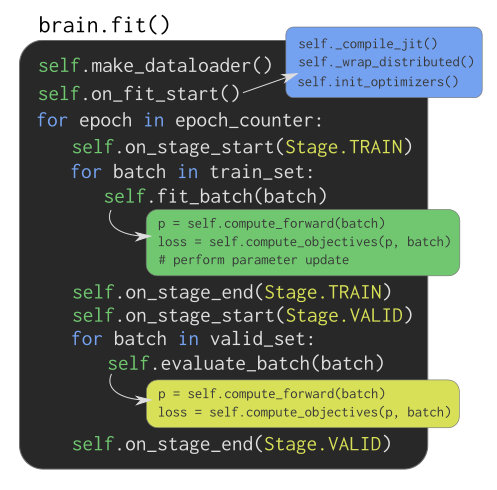


### `make_dataloader`

The first step of the `fit()` method is to ensure that the data is in an appropriate format for iteration. Both the `train_set` and `valid_set` are passed along with their respective keyword arguments. Here's the actual code:

```python
if not isinstance(train_set, DataLoader):
    train_set = self.make_dataloader(
        train_set, stage=sb.Stage.TRAIN, **train_loader_kwargs
    )
if valid_set is not None and not isinstance(valid_set, DataLoader):
    valid_set = self.make_dataloader(
        valid_set,
        stage=sb.Stage.VALID,
        ckpt_prefix=None,
        **valid_loader_kwargs,
    )
```

By default, this method handles potential complications to DataLoader creation, such as creating a DistributedSampler for distributed execution. As with all the other methods in the `fit()` call, this can be overridden by creating a `make_dataloader` method in the Brain's sub-class definition.

### `on_fit_start`

Besides the dataloader, there's some setup that needs to happen before the training can begin. Here's the relevant code:

```python
self.on_fit_start()

if progressbar is None:
    progressbar = self.progressbar
```

The `on_fit_start` method takes care of a few important things, which can most easily be explained by sharing the code:

```python
def on_fit_start(self):
    self._compile_jit()
    self._wrap_distributed()
    self.init_optimizers()
    if self.checkpointer is not None:
        self.checkpointer.recover_if_possible(
            device=torch.device(self.device)
        )
```

Basically, this method ensures that the torch modules are prepared appropriately, including jit compilation, distributed wrapping, and initializing the optimizer with all of the relevant parameters. The optimizer initialization also adds the optimizer parameters to the checkpointer if there is one. Finally, this method loads the latest checkpoint in order to resume training if it was interrupted.

### `on_stage_start`

This next section starts the epoch iteration and prepares for iterating the train data. To adjust the preparation one can override the `on_stage_start` method, which will allow for things like creating containers to store training statistics.

```python
for epoch in epoch_counter:
    self.on_stage_start(Stage.TRAIN, epoch)
    self.modules.train()
    self.nonfinite_count = 0
    if self.train_sampler is not None and hasattr(
        self.train_sampler, "set_epoch"
    ):
        self.train_sampler.set_epoch(epoch)
    last_ckpt_time = time.time()
```

### Training loop

The longest blocks of code in this tutorial are devoted to training and validation data loops. However, they really only do three important things:

1.   Call `fit_batch()` on each batch in the DataLoader.
2.   Track average loss and report it.
3.   Optionally save a checkpoint periodically so training can be resumed.

Here's the code:

```python
enable = progressbar and sb.utils.distributed.if_main_process()
with tqdm(
    train_set, initial=self.step, dynamic_ncols=True, disable=not enable,
) as t:
    for batch in t:
        self.step += 1
        loss = self.fit_batch(batch)
        self.avg_train_loss = self.update_average(
            loss, self.avg_train_loss
        )
        t.set_postfix(train_loss=self.avg_train_loss)

        if self.debug and self.step == self.debug_batches:
            break

        if (
            self.checkpointer is not None
            and self.ckpt_interval_minutes > 0
            and time.time() - last_ckpt_time
            >= self.ckpt_interval_minutes * 60.0
        ):
            run_on_main(self._save_intra_epoch_ckpt)
            last_ckpt_time = time.time()
```

Perhaps the most important step is the `fit_batch(batch)` call, which we show a trimmed version of here:

```python
def fit_batch(self, batch):
    outputs = self.compute_forward(batch, Stage.TRAIN)
    loss = self.compute_objectives(outputs, batch, Stage.TRAIN)
    loss.backward()
    if self.check_gradients(loss):
        self.optimizer.step()
    self.optimizer.zero_grad()
    return loss.detach().cpu()
```

This method calls the most important methods for fitting, `compute_forward` and `compute_objectives` that both must be overridden in order to use the Brain class. Then the loss is backpropagated and the gradients are checked for non-finite values and excessively large norms before the update is applied (large norms are automatically clipped by default).

### `on_stage_end`

At the end of the training loop, the `on_stage_end` method is called for potential cleanup operations, such as reporting training statistics.

```python
self.on_stage_end(Stage.TRAIN, self.avg_train_loss, epoch)
self.avg_train_loss = 0.0
self.step = 0
```

### Validation loop

Much like the training loop, the validation loop iterates the dataloader and handles one batch of data at a time. However, instead of calling `fit_batch` this loop calls `evaluate_batch` which does not backpropagate the gradient or apply any updates.

```python
if valid_set is not None:
    self.on_stage_start(Stage.VALID, epoch)
    self.modules.eval()
    avg_valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(
            valid_set, dynamic_ncols=True, disable=not enable
        ):
            self.step += 1
            loss = self.evaluate_batch(batch, stage=Stage.VALID)
            avg_valid_loss = self.update_average(
                loss, avg_valid_loss
            )

            if self.debug and self.step == self.debug_batches:
                break
```

### `on_stage_end`

This method is the same one as the method for the train stage, but this time is only executed on a single process, since often the process will involve writing to files. Common uses include: updating learning rate, saving a checkpoint, and recording statistics for an epoch.

```python
self.step = 0
run_on_main(
    self.on_stage_end,
    args=[Stage.VALID, avg_valid_loss, epoch],
)
```

The very last thing is a simple check for debug mode, to run only a few epochs.

```python
if self.debug and epoch == self.debug_epochs:
    break
```

Congrats, you now know how the `fit()` method works, and why it is a useful tool for running experiments. All of the parts of training a model are broken down and the annoying bits are taken care of, while full flexibility is still available by overriding any part of the Brain class.

## The `evaluate()` method

This method iterates the test data in much the same way as the validation data of the `fit()` method, including calls to `on_stage_start` and `on_stage_end`. One additional method that is called is the `on_evaluate_start()` method, which by default loads the best checkpoint for evaluation.



## Conclusion

The Brain class and the `fit()` method in particular were inspired by other popular Python libraries for statistics and machine learning, notably numpy, scipy, keras and PyTorch Lightning.

As we add tutorials about more advanced usage of Brain class, we will add links to them here. Some examples of planned tutorials:

*   Writing a GAN with the Brain class
*   Distributed training with the Brain class
*   Non-gradient-based usage of the Brain class



## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```